# The best of both worlds: Hierarchical Linear Regression in PyMC3

First, we'll load the data: 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())

In [2]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval to model.
Applied interval-transform to eps and added transformed eps_interval to model.


In [3]:
with hierarchical_model:
    means, sds, elbos = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -5649.16
Iteration 10000 [10%]: ELBO = -2588.56
Iteration 20000 [20%]: ELBO = -1546.06
Iteration 30000 [30%]: ELBO = -1140.9
Iteration 40000 [40%]: ELBO = -1111.36
Iteration 50000 [50%]: ELBO = -1080.17
Iteration 60000 [60%]: ELBO = -1117.1
Iteration 70000 [70%]: ELBO = -1086.79
Iteration 80000 [80%]: ELBO = -1095.07
Iteration 90000 [90%]: ELBO = -1104.33
Finished [100%]: ELBO = -1086.85


In [4]:
# Inference button (TM)!
with hierarchical_model:
    #start = pm.find_MAP()
    step = pm.NUTS(scaling=means)
    hierarchical_trace = pm.sample(5000, step, start=means, progressbar=False)

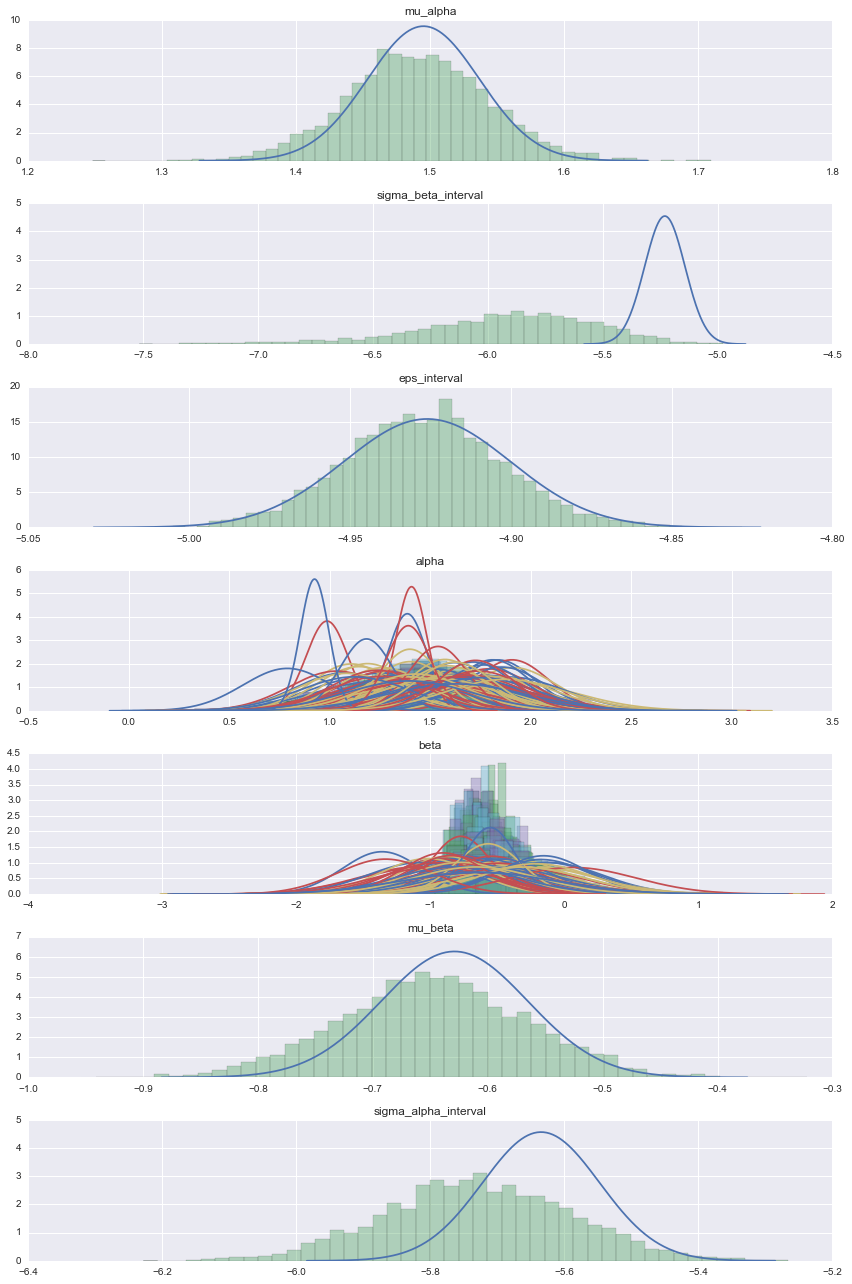

In [5]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()

Plotting the hierarchical model trace -its found values- from 500 iterations onwards (right side plot) and its accumulated marginal values (left side plot) 

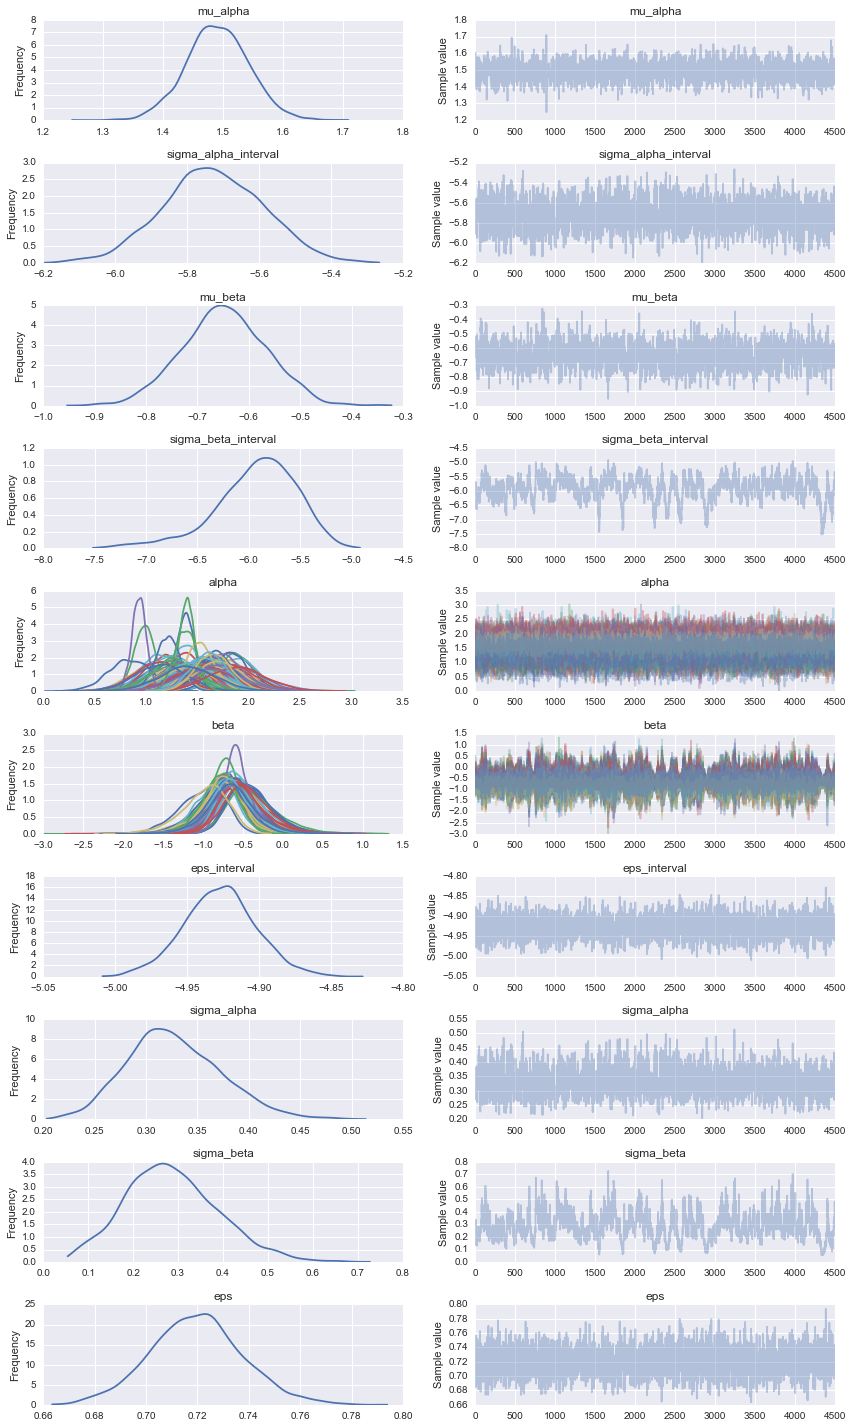

In [6]:
pm.traceplot(hierarchical_trace[500:]);

The marginal posteriors in the left column are highly informative. `mu_a` tells us the group mean (log) radon levels. `mu_b` tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for `a` that there is quite some differences in radon levels between counties (each 'rainbow' color corresponds to a single county); the different widths are related to how much confidence we have in each paramter estimate -- the more measurements per county, the higher our confidence will be.

# Posterior Predictive Check

## The Root Mean Square Deviation

To find out which of the models explains the data better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD (code not shown) we get the following result:

  * individual/non-hierarchical model: 0.13
  * hierarchical model: 0.08

As can be seen above the hierarchical model performs better than the non-hierarchical model in predicting the radon values. Following this, we'll plot some examples of county's showing the actual radon measurements, the hierarchial predictions and the non-hierarchical predictions. 

NameError: name 'indiv_traces' is not defined

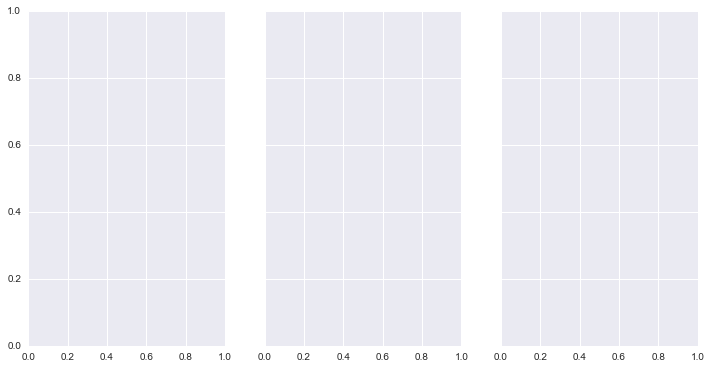

In [7]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.ix[data.county == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][500::10], indiv_traces[c]['beta'][500::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][500::10].mean() + indiv_traces[c]['beta'][500::10].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][500::10][z], hierarchical_trace['beta'][500::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][500::10][z].mean() + hierarchical_trace['beta'][500::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county 'CASS' we see that the non-hierarchical estimation is strongly biased: as this county's data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county's 'CROW WING' and 'FREEBORN' the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset ('CROW WING': no basement upper right. 'FREEBORN': basement upper left). Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county 'CROW WING''s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.

# Shrinkage
Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption, moving them closer to the group mean gives them higher probability. In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers (as shown above). 

In [ ]:
hier_a = hierarchical_trace['alpha'][500:].mean(axis=0)
hier_b = hierarchical_trace['beta'][500:].mean(axis=0)
indv_a = [indiv_traces[c]['alpha'][500:].mean() for c in county_names]
indv_b = [indiv_traces[c]['beta'][500:].mean() for c in county_names]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0, 3), ylim=(-3, 3))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
for i in range(len(indv_b)):  
    ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.04)
ax.legend();

In the shrinkage plot above we show the coefficients of each county's non-hierarchical posterior mean (blue) and the hierarchical posterior mean (red). To show the effect of shrinkage on a single coefficient-pair (alpha and beta) we connect the blue and red points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes too wide). Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 indicating that having a basement in almost all county's is a clear indicator for heightened radon levels. The intercept (which we take for type of soil) appears to differ among countys. This information would have been difficult to find if we had only used the non-hierarchial model.

Critically, many effects that look quite large and significant in the non-hiearchical model actually turn out to be much smaller when we take the group distribution into account (this point can also well be seen in plot `In[12]` in [Chris' NB](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb)). Shrinkage can thus be viewed as a form of smart regularization that helps reduce false-positives!

## Connections to Frequentist statistics

This type of hierarchical, partial pooling model is known as a [random effects model](https://en.wikipedia.org/wiki/Random_effects_model) in frequentist terms. Interestingly, if we placed uniform priors on the group mean and variance in the above model, the resulting Bayesian model would be equivalent to a random effects model. One might imagine that the difference between a model with uniform or wide normal hyperpriors should not have a huge impact. However, [Gelman says](http://andrewgelman.com/2014/03/15/problematic-interpretations-confidence-intervals/) encourages use of weakly-informative priors (like we did above) over flat priors.

# Summary

In this post, co-authored by Danne Elbers, we showed how a multi-level hierarchical Bayesian model gives the best of both worlds when we have multiple sets of measurements we expect to have similarity. The naive approach either pools all data together and ignores the individual differences, or treats each set as completely separate leading to noisy estimates, as shown above. By assuming that each individual data set (each county in our case) is distributed according to a group distribution -- which we simultaneously estimate -- we benefit from increased statistical power and smart regularization via the shrinkage effect. Probabilistic Programming in [PyMC](https://github.com/pymc-devs/pymc) then makes Bayesian estimation of this model trivial.

As a follow-up we could also include other states into our model. For this we could add yet another layer to the hierarchy where each state is pooled at the country level. Finally, readers of my blog will notice that we didn't use `glm()` here as it does not play nice with hierarchical models yet.

##References
  * [The underlying Notebook of this blog post](https://rawgithub.com/twiecki/WhileMyMCMCGentlySamples/master/content/downloads/notebooks/GLM_hierarchical.ipynb)
  * Blog post: [The Inference Button: Bayesian GLMs made easy with PyMC3](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * Blog post: [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  
  * [Chris Fonnesbeck repo containing a more extensive analysis](https://github.com/fonnesbeck/multilevel_modeling/)
  * Blog post: [Shrinkage in multi-level hierarchical models](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html) by John Kruschke
  * Gelman, A.; Carlin; Stern; and Rubin, D., 2007, "Replication data for: Bayesian Data Analysis, Second Edition", 
  * Gelman, A., & Hill, J. (2006). [Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.](http://www.amazon.com/Analysis-Regression-Multilevel-Hierarchical-Models/dp/052168689X)
  * Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.
  
## Acknowledgements
Thanks to [Imri Sofer](http://serre-lab.clps.brown.edu/person/imri-sofer/) for feedback and teaching us about the connections to random-effects models and [Dan Dillon](http://cdasr.mclean.harvard.edu/index.php/about-us/current-lab-members/14-faculty/62-daniel-dillon) for useful comments on an earlier draft.